### General use of PYMC3:

In [75]:
%matplotlib inline
import numpy as np
import pymc3 as pm
import seaborn as sns
import matplotlib.pyplot as plt
plt.style.use('seaborn-darkgrid')

#### Model creation
Models in PyMC3 are centered around the Model class. It has references to all random variables (RVs) and computes the model logp and its gradients. Usually, you would instantiate it as part of a with context

**pm.Model** (parent for the new instance) encapsulates the variables and likelihood factors of a model. Used for creating class based models. All variables defined within instance will be passed to the parent instance.

In [2]:
with pm.Model() as parent_model:
    # Model definition
    pass

In [3]:
with pm.Model() as parent_model:
    mu  = pm.Normal('mu', mu = 0., sigma = 1.)
    obs = pm.Normal('obs', mu = 0., sigma = 1., observed = np.random.randn(100)) 

In [4]:
parent_model.basic_RVs

[mu, obs]

In [5]:
parent_model.free_RVs

[mu]

In [6]:
parent_model.observed_RVs

[obs]

In [7]:
parent_model.logp({'mu': 0}) # logp puts together a function based on the current state of the model.

array(-141.79457945)

    The LogP machine is a model for parallel computation. It aims at being more practical than the PRAM model while still allowing for easy analysis of computation. The name is not related to the mathematical logarithmic function: Instead, the machine is described by the four parameters L, o, g, and P.

    The LogP machine consists of arbitrarily many processing units with distributed memory. The processing units are connected through an abstract communication medium which allows point-to-point communication. This model is pair-wise synchronous and overall asynchronous.

    The machine is described by the four parameters:
    
    L, the latency of the communication medium.
    
    o, the overhead of sending and receiving a message.
    
    g, the gap required between two send/receive operations. A more common interpretation of this quantity is as the inverse of the bandwidth of a processor-processor communication channel.
    
    P, the number of processing units. Each local operation on each machine takes the same time ('unit time'). This time is called a processor cycle.
    
    The units of the parameters L, o and g are measured in multiples of processor cycles.

In [9]:
%timeit parent_model.logp({'mu':0})
logp = parent_model.logp
%timeit logp({'mu':0})

56.8 ms ± 848 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)
23.6 µs ± 628 ns per loop (mean ± std. dev. of 7 runs, 10000 loops each)


#### Probability Distribution
Every probabilistic program consists of observed and unobserved Random Variables (RVs). **Observed** RVs are defined via **likelihood distributions**, while **unobserved** RVs are defined via **prior distributions**. In PyMC3, probability distributions are available from the main module space:

In [20]:
mu.logp({'mu':0})

array(-0.91893853)

##### Algebra :

PyMC3 allows doing any algebra:

In [22]:
with pm.Model():
    x = pm.Normal('x', mu=0, sd=1)
    y = pm.Gamma('y', alpha=1, beta=1)
    plus_2 = x + 2
    summed = x + y
    squared = x**2
    sined = pm.math.sin(x)

While these transformations work seamlessly, their results are not stored automatically. Thus, if you want to keep track of a transformed variable, you have to use **pm.Deterministic:**

In [31]:
with pm.Model() as parent_model:
    x = pm.Normal('x', mu=0, sigma=1)
    plus_2 = pm.Deterministic('plus_2', x + 2)

##### Automatic transforms of bounded RVs
In order to sample models more efficiently, PyMC3 automatically transforms bounded RVs to be unbounded.

In [28]:
with pm.Model() as parent_model:
    x = pm.Uniform('x', lower = 0, upper = 1)

When we look at the RVs of the model, we would expect to find x there, however:

In [29]:
parent_model.free_RVs

[x_interval__]

x_interval__ represents x transformed to accept parameter values between -inf and +inf. In the case of an upper and a lower bound, a LogOdds transform is applied. Sampling in this transformed space makes it easier for the sampler. PyMC3 also keeps track of the non-transformed, bounded parameters. These are common determinstics (see above):

In [30]:
parent_model.deterministics

[x]

### Inference
Once we have defined our model, we have to perform inference to approximate the posterior distribution. PyMC3 supports two broad classes of inference: sampling and variational inference.

#### Sampling
The main entry point to MCMC sampling algorithms is via the pm.sample() function. By default, this function tries to auto-assign the right sampler(s) and auto-initialize if you don’t pass anything.

In [57]:
with pm.Model() as parent_model :
    mu = pm.Normal('mu', mu=0, sigma=1)
    obs = pm.Normal('obs', mu=mu, sigma=1, observed=np.random.randn(100))
    
    trace = pm.sample(1000, tune=500)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [mu]
Sampling 2 chains, 0 divergences: 100%|██████████| 3000/3000 [00:01<00:00, 1578.57draws/s]


As you can see, on a continuous model, PyMC3 assigns the NUTS sampler, which is very efficient even for complex models. PyMC3 also runs variational inference (i.e. ADVI) to find good starting parameters for the sampler. Here we draw 1000 samples from the posterior and allow the sampler to adjust its parameters in an additional 500 iterations. These 500 samples are discarded by default:

In [37]:
len(trace)

1000

You can also run multiple chains in parallel using the cores kwarg:

In [58]:
with pm.Model() as model:
    mu = pm.Normal('mu', mu=0, sigma=1)
    obs = pm.Normal('obs', mu=mu, sigma=1, observed=np.random.randn(100))

    trace = pm.sample(500,cores=4,tune=600)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [mu]
Sampling 4 chains, 0 divergences: 100%|██████████| 4400/4400 [00:02<00:00, 1712.77draws/s]


In [59]:
trace['mu'].shape

(2000,)

In [60]:
trace.nchains

4

In [61]:
trace.get_values('mu', chains=1).shape # get values of a single chain

(500,)

PyMC3, offers a variety of other samplers, found in pm.step_methods.

In [62]:
list(filter(lambda x: x[0].isupper(), dir(pm.step_methods)))

['BinaryGibbsMetropolis',
 'BinaryMetropolis',
 'CategoricalGibbsMetropolis',
 'CauchyProposal',
 'CompoundStep',
 'DEMetropolis',
 'ElemwiseCategorical',
 'EllipticalSlice',
 'HamiltonianMC',
 'LaplaceProposal',
 'Metropolis',
 'MultivariateNormalProposal',
 'NUTS',
 'NormalProposal',
 'PoissonProposal',
 'Slice']

Commonly used step-methods besides NUTS are Metropolis and Slice. For almost all continuous models, ``NUTS`` should be preferred. There are hard-to-sample models for which NUTS will be very slow causing many users to use Metropolis instead. This practice, however, is rarely successful. NUTS is fast on simple models but can be slow if the model is very complex or it is badly initialized. In the case of a complex model that is hard for NUTS, Metropolis, while faster, will have a very low effective sample size or not converge properly at all. A better approach is to instead try to improve initialization of NUTS, or reparameterize the model.

For completeness, other sampling methods can be passed to sample:

In [63]:
with pm.Model() as model:
    mu = pm.Normal('mu', mu=0, sigma=1)
    obs = pm.Normal('obs', mu=mu, sigma=1, observed=np.random.randn(100))

    step = pm.Metropolis()
    trace = pm.sample(1000, step=step)

Multiprocess sampling (2 chains in 2 jobs)
Metropolis: [mu]
Sampling 2 chains, 0 divergences: 100%|██████████| 3000/3000 [00:00<00:00, 5291.96draws/s]
The number of effective samples is smaller than 25% for some parameters.


You can also assign variables to different step methods.

In [66]:
with pm.Model() as model:
    mu = pm.Normal('mu', mu=0, sigma=1)
    sd = pm.HalfNormal('sd', sigma=1)
    obs = pm.Normal('obs', mu=mu, sigma=sd, observed=np.random.randn(100))
    
    step1 = pm.Metropolis(vars=[mu])
    step2 = pm.Slice(vars=[sd])
    trace = pm.sample(10000, step=[step1, step2], cores=4)

Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>Metropolis: [mu]
>Slice: [sd]
Sampling 4 chains, 0 divergences: 100%|██████████| 42000/42000 [00:17<00:00, 2451.22draws/s]
The number of effective samples is smaller than 25% for some parameters.


#### Analyze sampling results
The most common used plot to analyze sampling results is the so-called trace-plot:

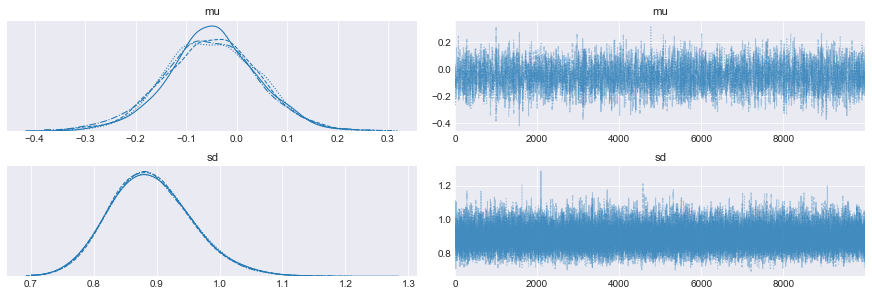

In [67]:
pm.traceplot(trace);

Finally, for a plot of the posterior that is inspired by the book Doing Bayesian Data Analysis, you can use the:

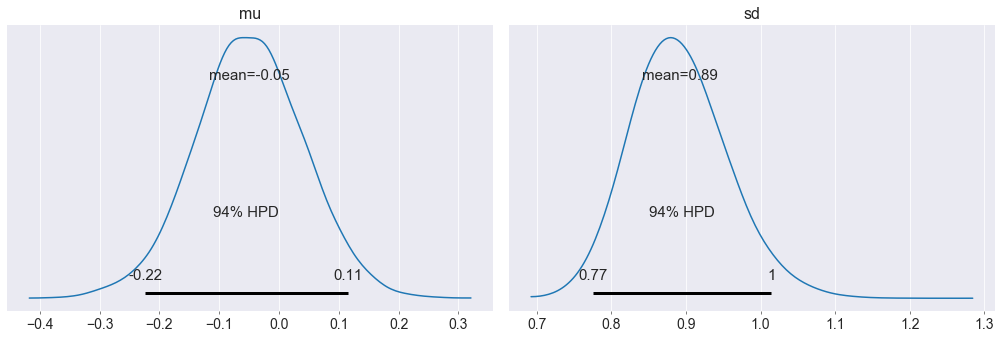

In [68]:
pm.plot_posterior(trace);

For high-dimensional models it becomes cumbersome to look at all parameter’s traces. When using NUTS we can look at the energy plot to assess problems of convergence:

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [x]
Sampling 4 chains, 0 divergences: 100%|██████████| 4000/4000 [00:03<00:00, 1088.20draws/s]


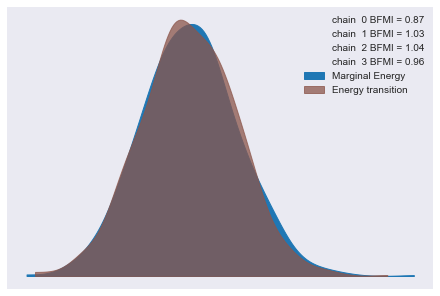

In [69]:
with pm.Model() as model:
    x = pm.Normal('x', mu=0, sigma=1, shape=100)
    trace = pm.sample(cores=4)

pm.energyplot(trace);

#### Posterior Predictive Sampling
The sample_posterior_predictive() function performs prediction on hold-out data and posterior predictive checks.

In [70]:
data = np.random.randn(100)
with pm.Model() as model:
    mu = pm.Normal('mu', mu=0, sigma=1)
    sd = pm.HalfNormal('sd', sigma=1)
    obs = pm.Normal('obs', mu=mu, sigma=sd, observed=data)

    trace = pm.sample()

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [sd, mu]
Sampling 2 chains, 0 divergences: 100%|██████████| 2000/2000 [00:01<00:00, 1741.81draws/s]


In [71]:
with model:
    post_pred = pm.sample_posterior_predictive(trace, samples=500)

/Users/Kamilobu/opt/anaconda3/lib/python3.7/site-packages/pymc3/sampling.py:1247: UserWarning: samples parameter is smaller than nchains times ndraws, some draws and/or chains may not be represented in the returned posterior predictive sample
  "samples parameter is smaller than nchains times ndraws, some draws "
100%|██████████| 500/500 [00:01<00:00, 298.48it/s]


sample_posterior_predictive() returns a dict with a key for every observed node:

In [72]:
post_pred['obs'].shape

(500, 100)

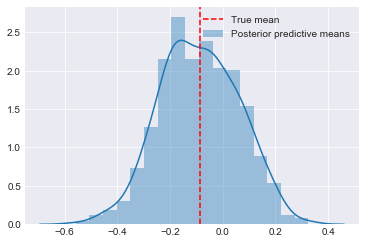

In [76]:
fig, ax = plt.subplots()
sns.distplot(post_pred['obs'].mean(axis=1), label='Posterior predictive means', ax=ax)
ax.axvline(data.mean(), ls='--', color='r', label='True mean')
ax.legend();

In [1]:
import pymc3 as pm

In [31]:
a = 614
n = 1504

alpha = 0.5
beta = 0.5

with pm.Model() as model:
    theta = pm.Beta('theta', alpha, beta)
    X = pm.Binomial('X', n, theta, observed=a)

In [33]:
with model:
    step = pm.NUTS()
    trace = pm.sample(5000, step=step)

Multiprocess sampling (2 chains in 2 jobs)
NUTS: [theta]
Sampling 2 chains, 0 divergences: 100%|██████████| 11000/11000 [00:04<00:00, 2346.53draws/s]


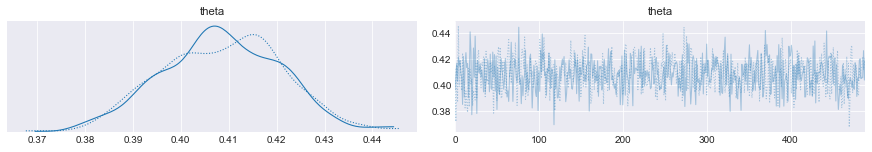

In [34]:
pm.traceplot(trace[100:][::10]);

In [27]:
trace.varnames

['theta_logodds__', 'theta']

In [89]:
bs   = 4 
b    = 4
Non  = 4
Noff = 4
Ton  = 1.
Toff = 2.4

# fit a pymc3 model to get the rate
basic_model = pm.Model()
with basic_model:
    s = pm.Uniform('s',0, 12)
    b  = pm.Poisson('b', mu = (Noff+1)/Toff )
    # likelihood
    Non_obs_s = pm.Poisson('Non_obs_s', mu = s + b, observed = Non)
    Non_obs_b = pm.Poisson('Non_obs_b', mu = b, observed = Non)

In [90]:
with basic_model:
    step = pm.NUTS()
    trace = pm.sample(5000, chains = 2, step=step)

Multiprocess sampling (2 chains in 2 jobs)
CompoundStep
>NUTS: [s]
>Metropolis: [b]
Sampling 2 chains, 0 divergences: 100%|██████████| 11000/11000 [00:06<00:00, 1765.23draws/s]
The acceptance probability does not match the target. It is 0.8927984779736381, but should be close to 0.8. Try to increase the number of tuning steps.
The number of effective samples is smaller than 25% for some parameters.


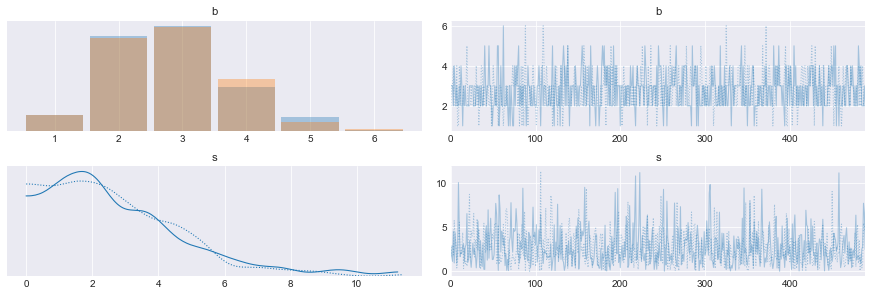

In [91]:
pm.traceplot(trace[100:][::10]);

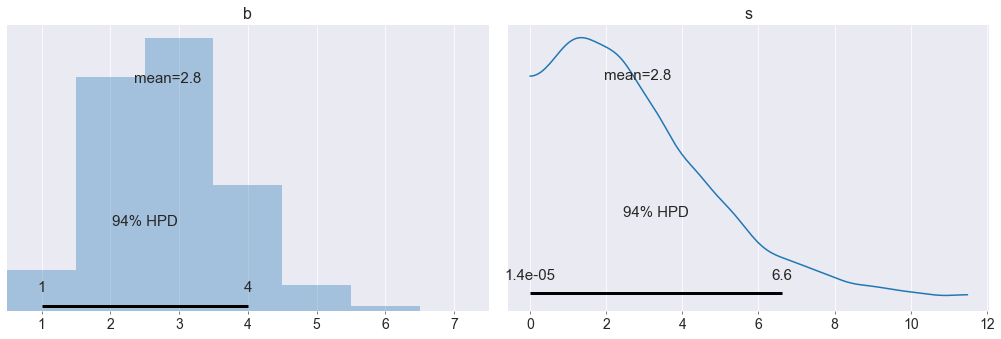

In [92]:
pm.plot_posterior(trace);

In [ ]:
with basic_model:
    trace = pm.sample(2000,cores = 1,chains = 5,tune = 10000)
    pm.traceplot(trace)
    plt.show()